<a href="https://colab.research.google.com/github/Prabuddha747/HOMOMORPHISM/blob/main/POC_HOMOMORPHISM_USING_TENSEAL_LIBRARY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ABOUT THE HOMOMORPHISM USING TENSEAL LIBRARY


TenSEAL is a library for doing homomorphic encryption operations on tensors. It's built on top of [Microsoft SEAL](https://github.com/Microsoft/SEAL), a C++ library implementing the BFV and CKKS homomorphic encryption schemes. TenSEAL provides ease of use through a Python API, while preserving efficiency by implementing most of its operations using C++, so TenSEAL is a C++ library with a Python interface.


## About Homomorphic Encryption

__Definition__ : Homomorphic encryption (HE) is an encryption technique that allows computations to be made on ciphertexts and generates results that when decrypted, correspond to the results of the same computations made on plaintexts.

This means that an HE scheme lets you encrypt two numbers *X* and *Y*, add their encrypted versions so that the result gets decrypted to *X + Y*. The same works for multiplication. If we translate this to Python, it may look something like this:

```python
x = 7
y = 3

x_encrypted = HE.encrypt(x)
y_encrypted = HE.encrypt(y)

z_encrypted = x_encrypted + y_encrypted

# z should now be x + y = 10
z = HE.decrypt(z_encrypted)


```

Many details are hidden in this Python script, things like key generation doesn't appear, and that `+` operation over encrypted numbers isn't the usual `+` over integers, but a special evaluation algorithm that can evaluate addition over encrypted numbers. TenSEAL supports addition, subtraction and multiplication of encrypted vectors of either integers (using BFV) or real numbers (using CKKS).

## About TenSEAL and Importing TenSEALContext

The TenSEALContext is a special object that holds different encryption keys and parameters for us, so that we only need to use a single object to make your encrypted computation instead of managing all the keys and the HE details. Basically,we have to create a single TenSEALContext before doing your encrypted computation.

In [2]:
!pip install tenseal
import tenseal as ts

context = ts.context(ts.SCHEME_TYPE.BFV, poly_modulus_degree=4096, plain_modulus=1032193)
context

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 35.1 MB/s eta 0:00:00


That's it ! We need to specify the HE scheme (we are using BFV here) that we want to use, as well as its parameters.
Our TenSEALContext is now holding the secret key and you can decrypt without the need to provide it, however, we can choose to manage it as a separate object and you will need to pass it to functions that require the secret key.

In [3]:
public_context = ts.context(ts.SCHEME_TYPE.BFV, poly_modulus_degree=4096, plain_modulus=1032193)
print("Is the context private?", ("Yes" if public_context.is_private() else "No"))
print("Is the context public?", ("Yes" if public_context.is_public() else "No"))

sk = public_context.secret_key()

# the context will drop the secret-key at this point
public_context.make_context_public()
print("Secret-key dropped")
print("Is the context private?", ("Yes" if public_context.is_private() else "No"))
print("Is the context public?", ("Yes" if public_context.is_public() else "No"))

Is the context private? Yes
Is the context public? No
Secret-key dropped
Is the context private? No
Is the context public? Yes


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


You can now try to fetch the secret key from the `public_context` and see that it raises an error. We will now continue using our first created TenSEALContext `context` which is still holding the secret key.

## Encryption and Evaluation

The next step after creating our TenSEALContext is to start doing some encrypted computation. First, we create an encrypted vector of integers.

In [5]:
plain_vector = [60, 66, 73, 81, 90]
encrypted_vector = ts.bfv_vector(context, plain_vector)
print("Encrypting our plaintext vector of size:", encrypted_vector.size())
encrypted_vector

Encrypting our plaintext vector of size: 5


Here we encrypted a vector of integers into a BFVVector, a vector type that uses the BFV scheme. Now we can do both addition, subtraction and multiplication in an element-wise fashion** with other encrypted or plain vectors.**

In [6]:
add_result = encrypted_vector + [1, 2, 3, 4, 5]
print(add_result.decrypt())

[61, 68, 76, 85, 95]


In [7]:
sub_result = encrypted_vector - [1, 2, 3, 4, 5]
print(sub_result.decrypt())

[59, 64, 70, 77, 85]


In [8]:
mul_result = encrypted_vector * [1, 2, 3, 4, 5]
print(mul_result.decrypt())

[60, 132, 219, 324, 450]


In [9]:
encrypted_add = add_result + sub_result
print(encrypted_add.decrypt())

[120, 132, 146, 162, 180]


In [10]:
encrypted_sub = encrypted_add - encrypted_vector
print(encrypted_sub.decrypt())

[60, 66, 73, 81, 90]


In [11]:
encrypted_mul = encrypted_add * encrypted_sub
print(encrypted_mul.decrypt())

[7200, 8712, 10658, 13122, 16200]


We just made both ciphertext to plaintext (c2p) and ciphertext to ciphertext (c2c) evaluations (add, sub and mul). A**n important thing to note is that we should never encrypt your plaintext values to evaluate them with ciphertexts if they don't need to be kept private. That's because c2p evaluations are more efficient than c2c. Because a c2p multiplication is faster compared to a c2c one.**

In [12]:
from time import time

t_start = time()
_ = encrypted_add * encrypted_mul
t_end = time()
print("c2c multiply time: {} ms".format((t_end - t_start) * 1000))

t_start = time()
_ = encrypted_add * [1, 2, 3, 4, 5]
t_end = time()
print("c2p multiply time: {} ms".format((t_end - t_start) * 1000))

c2c multiply time: 7.736444473266602 ms
c2p multiply time: 1.8131732940673828 ms



**More about TenSEALContext**

TenSEALContext is holding more attributes than what we have seen so far,the ones for setting automatic relinearization, rescaling (for CKKS only) and modulus switching. These features are enabled by default as you can see below:

In [14]:
print("Automatic relinearization is:", ("on" if context.auto_relin else "off"))
print("Automatic rescaling is:", ("on" if context.auto_rescale else "off"))
print("Automatic modulus switching is:", ("on" if context.auto_mod_switch else "off"))

Automatic relinearization is: on
Automatic rescaling is: off
Automatic modulus switching is: off


# Training and Evaluation of Logistic Regression on Encrypted Data

The goal isn't to show how efficient logistic regression is for this task, we will just go with whatever accuracy we get, but the training and evaluation on encrypted data should be comparable to when we use plain data.

In [15]:
import torch
import tenseal as ts
import pandas as pd
import random
from time import time
import numpy as np
import matplotlib.pyplot as plt

Preparing the training and test data. This dataset includes patients' information along with a 10-year risk of future coronary heart disease (CHD) as a label. The goal is to build a model that can predict this 10-year CHD risk based on patients' information.

In [17]:
torch.random.manual_seed(73)
random.seed(73)


def split_train_test(x, y, test_ratio=0.3):
    idxs = [i for i in range(len(x))]
    random.shuffle(idxs)
    # delimiter between test and train data
    delim = int(len(x) * test_ratio)
    test_idxs, train_idxs = idxs[:delim], idxs[delim:]
    return x[train_idxs], y[train_idxs], x[test_idxs], y[test_idxs]


def heart_disease_data():
    data = pd.read_csv("/content/sample_data/framingham.csv")
    # drop rows with missing values
    data = data.dropna()
    # drop some features
    data = data.drop(columns=["education", "currentSmoker", "BPMeds", "diabetes", "diaBP", "BMI"])
    # balance data
    grouped = data.groupby('TenYearCHD')
    data = grouped.apply(lambda x: x.sample(grouped.size().min(), random_state=73).reset_index(drop=True))
    # extract labels
    y = torch.tensor(data["TenYearCHD"].values).float().unsqueeze(1)
    data = data.drop(columns=["TenYearCHD"]) # Pass 'columns' as a keyword argument
    # standardize data
    data = (data - data.mean()) / data.std()
    x = torch.tensor(data.values).float()
    return split_train_test(x, y)


def random_data(m=1024, n=2):

    x_train = torch.randn(m, n)
    x_test = torch.randn(m // 2, n)
    y_train = (x_train[:, 0] >= x_train[:, 1]).float().unsqueeze(0).t()
    y_test = (x_test[:, 0] >= x_test[:, 1]).float().unsqueeze(0).t()
    return x_train, y_train, x_test, y_test
x_train, y_train, x_test, y_test = heart_disease_data()

print("############# Data summary #############")
print(f"x_train has shape: {x_train.shape}")
print(f"y_train has shape: {y_train.shape}")
print(f"x_test has shape: {x_test.shape}")
print(f"y_test has shape: {y_test.shape}")
print("#######################################")

############# Data summary #############
x_train has shape: torch.Size([780, 9])
y_train has shape: torch.Size([780, 1])
x_test has shape: torch.Size([334, 9])
y_test has shape: torch.Size([334, 1])
#######################################


<ipython-input-17-855b74085000>:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = grouped.apply(lambda x: x.sample(grouped.size().min(), random_state=73).reset_index(drop=True))


# Training a logistic regression model
**First without any encryption**
We will be using this model as a means of comparison against encrypted training and evaluation.

In [18]:
class LR(torch.nn.Module):

    def __init__(self, n_features):
        super(LR, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)

    def forward(self, x):
        out = torch.sigmoid(self.lr(x))
        return out


In [19]:
n_features = x_train.shape[1]
model = LR(n_features)
# use gradient descent with a learning_rate=1
optim = torch.optim.SGD(model.parameters(), lr=1)
# use Binary Cross Entropy Loss
criterion = torch.nn.BCELoss()

In [23]:
def train(model, optim, criterion, x, y, epochs=3):
    for e in range(1, epochs + 1):
        optim.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optim.step()
        print(f"Loss at epoch {e}: {loss.data}")
    return model

def train(model, optim, criterion, x, y, epochs=3):
    for e in range(1, epochs + 1):
        optim.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optim.step()
        print(f"Loss at epoch {e}: {loss.data}")
    return model # This line was incorrectly indented

model = train(model, optim, criterion, x_train, y_train)

Loss at epoch 1: 0.8504331707954407
Loss at epoch 2: 0.6863385438919067
Loss at epoch 3: 0.6358115077018738


In [24]:
def accuracy(model, x, y):
    out = model(x)
    correct = torch.abs(y - out) < 0.5
    return correct.float().mean()

plain_accuracy = accuracy(model, x_test, y_test)
print(f"Accuracy on plain test_set: {plain_accuracy}")

Accuracy on plain test_set: 0.697604775428772


High accuracy isn't our goal. We just want to see that training on encrypted data doesn't affect the final result, so we will be comparing accuracies over encrypted data against the plain_accuracy we got here.

**Encrypted Evaluation**
Focusing on evaluating the logistic regression model with plain parameters (optionally encrypted parameters) on the encrypted test set.

In [25]:
class EncryptedLR:

    def __init__(self, torch_lr):
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()

    def forward(self, enc_x):
        enc_out = enc_x.dot(self.weight) + self.bias
        return enc_out

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)

    def decrypt(self, context):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()


eelr = EncryptedLR(model)

In [26]:
# parameters
poly_mod_degree = 4096
coeff_mod_bit_sizes = [40, 20, 40]
# create TenSEALContext
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
# scale of ciphertext to use
ctx_eval.global_scale = 2 ** 20
# this key is needed for doing dot-product operations
ctx_eval.generate_galois_keys()


t_start = time()
enc_x_test = [ts.ckks_vector(ctx_eval, x.tolist()) for x in x_test]
t_end = time()
print(f"Encryption of the test-set took {int(t_end - t_start)} seconds")

Encryption of the test-set took 0 seconds


In [28]:
def encrypted_evaluation(model, enc_x_test, y_test):
    t_start = time()

    correct = 0
    for enc_x, y in zip(enc_x_test, y_test):
        # encrypted evaluation
        enc_out = model(enc_x)
        # plain comparison
        out = enc_out.decrypt()
        out = torch.tensor(out)
        out = torch.sigmoid(out)
        if torch.abs(out - y) < 0.5:
            correct += 1

    t_end = time()
    print(f"Evaluated test_set of {len(x_test)} entries in {int(t_end - t_start)} seconds")
    print(f"Accuracy: {correct}/{len(x_test)} = {correct / len(x_test)}")
    return correct / len(x_test)


encrypted_accuracy = encrypted_evaluation(eelr, enc_x_test, y_test)
diff_accuracy = plain_accuracy - encrypted_accuracy
print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")
if diff_accuracy < 0:
    print(" A better accuracy on the encrypted test-set is obtained :)")

Evaluated test_set of 334 entries in 1 seconds
Accuracy: 192/334 = 0.5748502994011976
Difference between plain and encrypted accuracies: 0.12275445461273193


# Training an Encrypted Logistic Regression Model on Encrypted Data

From the input data to the parameter update, a ciphertext will need a multiplicative depth of 6, 1 for the dot product operation, 2 for the sigmoid approximation, and 3 for the backpropagation phase (one is actually hidden in the self._delta_w += enc_x * out_minus_y operation in the backward() function, which is multiplying a 1-sized vector with an n-sized one, which requires masking the first slot and replicating it n times in the first vector). With a scale of around 20 bits, we need 6 coefficients modulus with the same bit-size as the scale, plus the last coefficient, which needs more bits, we are already out of the 4096 polynomial modulus degree (which requires < 109 total bit count of the coefficients modulus, if we consider 128-bit security), so we will use 8192. This will allow us to batch up to 4096 values in a single ciphertext

In [29]:
class EncryptedLR:

    def __init__(self, torch_lr):
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()
        # we accumulate gradients and counts the number of iterations
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0

    def forward(self, enc_x):
        enc_out = enc_x.dot(self.weight) + self.bias
        enc_out = EncryptedLR.sigmoid(enc_out)
        return enc_out

    def backward(self, enc_x, enc_out, enc_y):
        out_minus_y = (enc_out - enc_y)
        self._delta_w += enc_x * out_minus_y
        self._delta_b += out_minus_y
        self._count += 1

    def update_parameters(self):
        if self._count == 0:
            raise RuntimeError(" at least run one forward iteration")
        # update weights
        # We use a small regularization term to keep the output
        # of the linear layer in the range of the sigmoid approximation
        self.weight -= self._delta_w * (1 / self._count) + self.weight * 0.05
        self.bias -= self._delta_b * (1 / self._count)
        # reset gradient accumulators and iterations count
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0

    @staticmethod
    def sigmoid(enc_x):
        # We use the polynomial approximation of degree 3
        # sigmoid(x) = 0.5 + 0.197 * x - 0.004 * x^3
        return enc_x.polyval([0.5, 0.197, 0, -0.004])

    def plain_accuracy(self, x_test, y_test):
        # evaluate accuracy of the model on
        # the plain (x_test, y_test) dataset
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)
        correct = torch.abs(y_test - out) < 0.5
        return correct.float().mean()

    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)

    def decrypt(self):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

In [30]:
# parameters
poly_mod_degree = 8192
coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
# create TenSEALContext
ctx_training = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx_training.global_scale = 2 ** 21
ctx_training.generate_galois_keys()

In [31]:
t_start = time()
enc_x_train = [ts.ckks_vector(ctx_training, x.tolist()) for x in x_train]
enc_y_train = [ts.ckks_vector(ctx_training, y.tolist()) for y in y_train]
t_end = time()
print(f"Encryption of the training_set took {int(t_end - t_start)} seconds")


Encryption of the training_set took 24 seconds


Distribution on plain data:


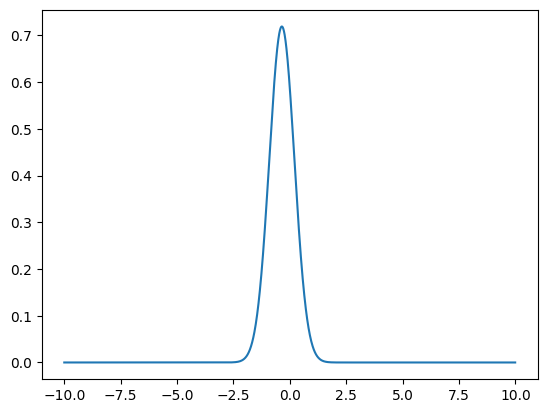

Distribution on encrypted data:


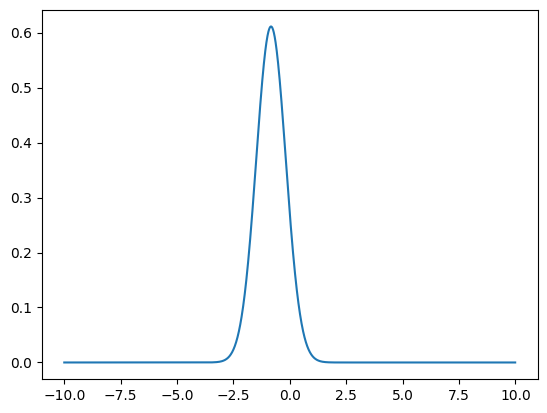

In [32]:
normal_dist = lambda x, mean, var: np.exp(- np.square(x - mean) / (2 * var)) / np.sqrt(2 * np.pi * var)

def plot_normal_dist(mean, var, rmin=-10, rmax=10):
    x = np.arange(rmin, rmax, 0.01)
    y = normal_dist(x, mean, var)
    fig = plt.plot(x, y)

# plain distribution
lr = LR(n_features)
data = lr.lr(x_test)
mean, var = map(float, [data.mean(), data.std() ** 2])
plot_normal_dist(mean, var)
print("Distribution on plain data:")
plt.show()

# encrypted distribution
def encrypted_out_distribution(eelr, enc_x_test):
    w = eelr.weight
    b = eelr.bias
    data = []
    for enc_x in enc_x_test:
        enc_out = enc_x.dot(w) + b
        data.append(enc_out.decrypt())
    data = torch.tensor(data)
    mean, var = map(float, [data.mean(), data.std() ** 2])
    plot_normal_dist(mean, var)
    print("Distribution on encrypted data:")
    plt.show()

eelr = EncryptedLR(lr)
eelr.encrypt(ctx_training)
encrypted_out_distribution(eelr, enc_x_train)

In [34]:
eelr = EncryptedLR(LR(n_features))
accuracy = eelr.plain_accuracy(x_test, y_test)
print(f"Accuracy at epoch #0 is {accuracy}")

times = []
for epoch in range(3):
    eelr.encrypt(ctx_training)
    t_start = time()
    for enc_x, enc_y in zip(enc_x_train, enc_y_train):
        enc_out = eelr.forward(enc_x)
        eelr.backward(enc_x, enc_out, enc_y)
    eelr.update_parameters()
    t_end = time()
    times.append(t_end - t_start)

    eelr.decrypt()
    accuracy = eelr.plain_accuracy(x_test, y_test)
    print(f"Accuracy at epoch #{epoch + 1} is {accuracy}")


print(f"\nAverage time per epoch: {int(sum(times) / len(times))} seconds")
print(f"Final accuracy is {accuracy}")

diff_accuracy = plain_accuracy - accuracy
print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")


Accuracy at epoch #0 is 0.37425148487091064
Accuracy at epoch #1 is 0.667664647102356
Accuracy at epoch #2 is 0.598802387714386
Accuracy at epoch #3 is 0.682634711265564

Average time per epoch: 129 seconds
Final accuracy is 0.682634711265564
Difference between plain and encrypted accuracies: 0.014970064163208008


In [37]:
if diff_accuracy < 1:
    print("better accuracy when training on encrypted data.")

better accuracy when training on encrypted data.
